# Progetto NLP Text summarization

L'obiettivo di questo progetto è la creazione di un modello di NLP in grado di **sintetizzare testi lunghi**, scritti in italiano, in poche righe di testo. Per farlo è stato necessario estrarre degli articoli tecnologici della rivista **IlPost**, successivamente è stato utilizzato un modello pre-addestrato **MBART** per continuare l'addestramento sui 160 articoli da noi estratti. Successivamente sono state calcolate le misure di accuratezza, e per concludere viene mostrato l'utilizzo del modello in un caso reale.

## **Librerie e Drive**

#### Installazioni librerie esterne

In [ ]:
!pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.6 MB/s eta 0:00:00


In [ ]:
!pip install rouge

In [ ]:
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.7 MB/s eta 0:00:00


### Librerie

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgba
from textacy import preprocessing
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import nltk
from nltk.translate.bleu_score import SmoothingFunction

<ipython-input-4-6325e601582a>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


### Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Creazione dataset**

#### Scraping pagine web

Il sito web IlPost è composto da varie sezioni, l'estrazione dei dati per la creazione del dataset avviene nell'ambito tecnologia. In ogni pagina della sezione Tecnologia sono presenti 20 articoli, lo scopo è estrarre il titolo principale, il titolo secondario e i paragrafi di ogni articolo. Il dataset è composto da due colonne, source e target, corrispettivamente saranno il testo lungo formato dall'unione di tutti i paragrafi di un articolo, e l'unione di titolo primario e secondario.

In [ ]:
def coppie(url):
  time.sleep(1)
  r = requests.get(url)
  soup = BeautifulSoup(r.text, "html5lib")
  articles = soup.find_all("article", class_="_taxonomy-item_q6jgq_1 _opener_q6jgq_14")
  # list of summaries
  summary = []
  for i in range(len(articles)):
    try:
      testo1 = articles[i].select_one("a").get_text().strip()
    except:
      testo1 = ""
    try:
      testo2 = articles[i].select_one("p").get_text().strip()
    except:
      testo2 = ""

    if testo1[-1] == "?":
      if testo2 == "": riassunto = testo1
      elif testo2[-1] == ".": riassunto = testo1 + " " + testo2
      else: riassunto = testo1 + " " + testo2[0].lower() + testo2[1:] + "."
    elif testo1[-1] == ",":
      if testo2 == "": riassunto = testo1[:-1] + "."
      elif testo2[-1] == ".": riassunto = testo1 + " " + testo2[0].lower() + testo2[1:]
      else: riassunto = testo1 + " " + testo2[0].lower() + testo2[1:] + "."
    elif testo1[-1] != ",":
      if testo2 == "": riassunto = testo1 + "."
      elif testo2[-1] == ".": riassunto = testo1 + ". " + testo2
      else: riassunto = testo1 + ". " + testo2 + "."

    summary.append((riassunto))

  # articles urls
  pagelinks = []
  print("lunghezza articoli: ", len(articles))

  for i in range(len(articles)):
    url = articles[i].find_all('a')[0]
    pagelinks.append(url.get('href'))

  thearticle = []
  paragraph_test = []
  print("lunghezza pagelinks: ", len(pagelinks))
  for link in pagelinks:
    paragraphtext = []
    url = link
    page = requests.get(url)
    time.sleep(0.2)
    soup = BeautifulSoup(page.text, 'html.parser')


    testo_articolo = soup.find_all("p")
    for paragraph in testo_articolo[:-1]:
        text = paragraph.get_text()
        paragraphtext.append(text)

    testo_fin = ' '.join(paragraphtext)
    thearticle.append(testo_fin)
  d = {'source': thearticle, 'target': summary}
  return d


In [ ]:
df_train = pd.DataFrame(columns=["source", "target"])
df_test = pd.DataFrame(columns=["source", "target"])
i = 0
j = 0
conto = 0
argomenti = "tecnologia"
numero_articoli = 160
numero_articoli_per_pagina = 20
numero_test = 3                 # ogni unità equivale a 20 articoli, però partendo da 2 in su.

for j in range(1, int(numero_articoli/numero_articoli_per_pagina)+1):
  if j == 1:
    ret = coppie("https://www.ilpost.it/" + argomenti+"/")
    conto += 20
    print("\nPagina: " + "https://www.ilpost.it/" + argomenti+"/"
    + "\nArticoli Scaricati: " + str(conto))
    df_train = pd.concat([df_train, pd.DataFrame(ret)])

  else:
    ret = coppie("https://www.ilpost.it/" + argomenti + "/page/" + str(j) +"/")
    conto += 20
    print("\nPagina: " + "https://www.ilpost.it/" + argomenti + "/page/" + str(j) +"/"
    + "\nArticoli Scaricati: " + str(conto))
    df_train = pd.concat([df_train, pd.DataFrame(ret)])

for j in range(int(numero_articoli/numero_articoli_per_pagina)+1, int(numero_articoli/numero_articoli_per_pagina)+numero_test):
    ret = coppie("https://www.ilpost.it/" + argomenti + "/page/" + str(j) +"/")
    print("\nPagina: " + "https://www.ilpost.it/" + argomenti + "/page/" + str(j) +"/")
    df_test = pd.concat([df_test, pd.DataFrame(ret)])

#### Cleaning

All'interno della funzione coppie avviene già una correzione quando titolo principale e secondario vengono uniti, per far si che il titolo principale termina con un punto e dopo lo spazio inizi il secondario. Questo cunck ha lo scopo di eliminare eventuali articoli che non sono stati catturati dallo scraping e quindi vengono segnati come vuoti.

In [ ]:
# some cleaning, remove empty rows
df_train['source'].replace("", np.nan, inplace=True)
df_train['target'].replace("", np.nan, inplace=True)
df_train.dropna(subset=['source'], inplace=True)
df_train.dropna(subset=['target'], inplace=True)
df_train = df_train.reset_index(drop=True)

print(df_train.source.size, df_train.target.size)

# some cleaning, remove empty rows
df_test['source'].replace("", np.nan, inplace=True)
df_test['target'].replace("", np.nan, inplace=True)
df_test.dropna(subset=['source'], inplace=True)
df_test.dropna(subset=['target'], inplace=True)
df_test = df_test.reset_index(drop=True)

print(df_test.source.size, df_test.target.size)

160 160
40 40


In [ ]:
df_train.to_csv("/content/drive/MyDrive/Prog_NLP/train.csv", sep=',', index=False)
df_test.to_csv("/content/drive/MyDrive/Prog_NLP/test.csv", sep=',', index=False)

#### Plot lunghezze riassunti

Visualizziamo attraverso un istogramma quante parole ci sono nelle sintesi composte dall'unione del titolo primario e secondario. Noteremo due curve dovute dal fatto che non tutti gli articoli dispongono del titolo secondario e dunque vi sarà una netta separazione tra la lunghezza di articoli con solo il titolo principale e quelli con titolo principale e secondario.

In [ ]:
word_bound = re.compile(r'\b')

def num_words(line):
    return len(word_bound.findall(line)) >> 1

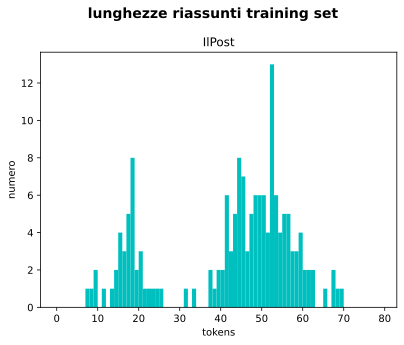

In [ ]:
ii = [i for i in range(0,80)]
lunghezze_riass = [num_words(df_train["target"].iloc[i]) for i in range(df_train.shape[0])]

fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

fig.suptitle('lunghezze riassunti training set', fontsize=14, fontweight='bold')
ax.set_title('IlPost')

ax.set_xlabel('tokens')
ax.set_ylabel('numero')

#plt.style.use(['dark_background'])
plt.hist(lunghezze_riass, bins=ii, color='c')

plt.show()

Nel prossimo grafico viene mostrata la lunghezza dei testi in numero di parole degli articoli formati dall'unione di tutti i paragrafi.

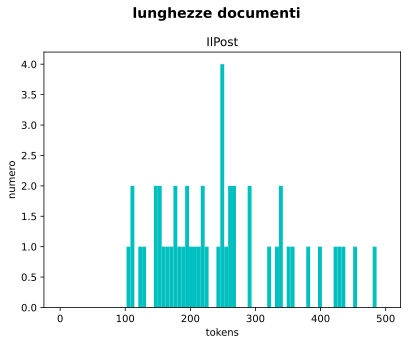

In [ ]:
ii = [i for i in range(0,500,6)]
lunghezze_docu = [num_words(df_train['source'].iloc[i]) for i in range(df_train.shape[0])]

fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

fig.suptitle('lunghezze documenti', fontsize=14, fontweight='bold')
ax.set_title('IlPost')

ax.set_xlabel('tokens')
ax.set_ylabel('numero')

#plt.style.use(['dark_background'])
plt.hist(lunghezze_docu, bins=ii, color='c')
plt.show()

#### Pre-processing

Necessaria prima della tokenizzazione una fase di pre processing dove il testo viene normalizzato attraverso la standardizzazione dei caratteri, vi è poi la rimozione dei tag di HTML, e la rimozione dei spazi bianchi.

In [ ]:
## Pre processing training set
df_train = pd.read_csv("/content/drive/MyDrive/Prog_NLP/train.csv")
df_train.shape[0]
clean_inputs = []
clean_targets = []

preproc = preprocessing.make_pipeline(
     preprocessing.normalize.unicode,
     preprocessing.remove.html_tags,
     preprocessing.normalize.whitespace
)

# apply to dataset elements
clean_inputs = [preproc(df_train["source"].iloc[i]) for i in range(df_train.shape[0])]
clean_targets = [preproc(df_train["target"].iloc[i]) for i in range(df_train.shape[0])]
df_train = pd.DataFrame({"source": clean_inputs, "target": clean_targets})

In [ ]:
## Pre processing test set
df_test = pd.read_csv("/content/drive/MyDrive/Prog_NLP/test.csv")
df_test.shape[0]
clean_inputs = []
clean_targets = []

preproc = preprocessing.make_pipeline(
     preprocessing.normalize.unicode,
     preprocessing.remove.html_tags,
     preprocessing.normalize.whitespace
)

# apply to dataset elements
clean_inputs = [preproc(df_test["source"].iloc[i]) for i in range(df_test.shape[0])]
clean_targets = [preproc(df_test["target"].iloc[i]) for i in range(df_test.shape[0])]
df_test = pd.DataFrame({"source": clean_inputs, "target": clean_targets})

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Prog_NLP/train_clean.csv", sep=',', index=False)
df_test.to_csv("/content/drive/MyDrive/Prog_NLP/test_clean.csv", sep=',', index=False)

## **Addestramento modello**

In questa parte di codice viene importato il modello pre-addestrato MBART dalla pagina web HuggingFace, al link: https://huggingface.co/ARTeLab/mbart-summarization-ilpost.

Successivamente viene addestrato attraverso il dataset costruito nei cunck precedenti attraverso lo scraping della pagina web IlPost.

#### Importiamo il modello pre-addestrato

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
tokenizer = MBartTokenizer.from_pretrained("ARTeLab/mbart-summarization-ilpost")
model = MBartForConditionalGeneration.from_pretrained("ARTeLab/mbart-summarization-ilpost")

tokenizer_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

#### Addestramento del modello

Iper-prametri utilizzati nei try

Sono stati segnati gli iperparametri modificati durante l'addestramento, il numero limitato di tentativi di fine-tuning è dovuto dal temine dei crediti di Colab.

**Primo Dataset 80 train, 20 test**

1| batch=8, lr=1e-6, epoch=5

2| batch=16, lr=1e-6, epoch=5

3| batch=4, lr=1e-6, epoch=5

4| batch=2, lr=1e-6, epoch=5

5| batch=2, lr=1e-6, epoch=10 BEST TRY

**Nuovo Dataset 160 train, 40 test**

6| batch=2, lr=1e-6, epoch=10 BEST TRY

7| batch=2, lr=1e-5, epoch=10


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train = pd.read_csv("/content/drive/MyDrive/Prog_NLP/train_clean.csv")
test = pd.read_csv("/content/drive/MyDrive/Prog_NLP/test_clean.csv")

train_texts = list(train["source"])
train_targets = list(train["target"])

test_texts = list(test["source"])
test_targets = list(test["target"])


# Tokenizzazione dei dati

train_inputs = tokenizer(train_texts, return_tensors="pt", padding=True, truncation=True)
train_labels = tokenizer(train_targets, return_tensors="pt", padding=True, truncation=True)

test_inputs = tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True)
test_labels = tokenizer(test_targets, return_tensors="pt", padding=True, truncation=True)


# Crea il dataset PyTorch
train_dataset = TensorDataset(train_inputs["input_ids"], train_labels["input_ids"])
test_dataset = TensorDataset(test_inputs["input_ids"], test_labels["input_ids"])
# Crea il dataloader per il training
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Definisci l'ottimizzatore, la loss function e altri parametri di addestramento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

loss_media_train = []

# Addestra il modello
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        inputs = batch[0]
        labels = batch[1]

        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_dataloader)
    loss_media_train.append(average_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}')

model.eval()
predictions = []
references = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0]
        labels = batch[1]

        outputs = model.generate(inputs)

        # Decodifica le predizioni e i riferimenti
        predicted_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Aggiungi le predizioni e i riferimenti alle liste
        predictions.extend(predicted_texts)
        references.extend(target_texts)

Epoch 1/10, Average Loss: 3.2964


Epoch 2/10, Average Loss: 1.5096


Epoch 3/10, Average Loss: 0.8434


Epoch 4/10, Average Loss: 0.6036


Epoch 5/10, Average Loss: 0.4193


Epoch 6/10, Average Loss: 0.3243


Epoch 7/10, Average Loss: 0.2443


Epoch 8/10, Average Loss: 0.1539


Epoch 9/10, Average Loss: 0.1060


Epoch 10/10, Average Loss: 0.0757


In [ ]:
# Salvataggio del modello
torch.save(model.state_dict(), '/content/drive/MyDrive/Prog_NLP/tesxsumm_bert.pkl')

#### **Grafico andamento loss**

#### **Curve di Loss**

Questo ti darà un'indicazione di come la loss cambia durante l'addestramento per il set di training. La curva di loss del training decresce costantemente.
Questo indica che il modello sta imparando bene dai dati di training. Purtroppo la curva non arriva in un punto in cui termina di decrescere, ma a causa della limitazione nei crediti di Colab non è stato possibile utilizzare l'early stopping per terminare l'addestramento quando la loss per le epoche era la stessa.

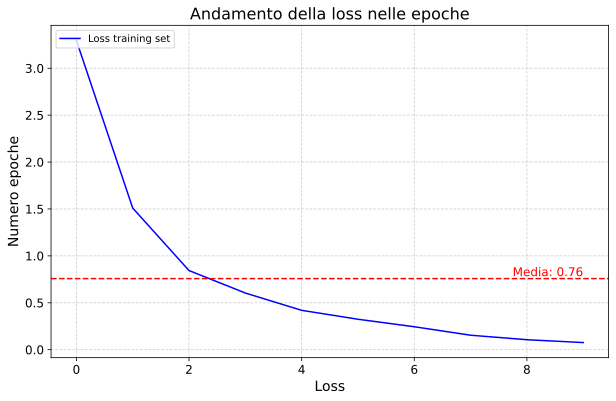

In [ ]:
import matplotlib.pyplot as plt

# Lista della loss del training set
loss_train = loss_media_train

# Plot della loss
plt.figure(figsize=(10, 6))  # Imposta le dimensioni della figura

# Imposta lo stile della linea senza marker
plt.plot(loss_train, linestyle='-', color='b', label='Loss training set')

# Aggiungi titoli e etichette agli assi
plt.title('Andamento della loss nelle epoche', fontsize=16)
plt.xlabel('Loss', fontsize=14)
plt.ylabel('Numero epoche', fontsize=14)

# Aggiungi una griglia per facilitare la lettura del grafico
plt.grid(True, linestyle='--', alpha=0.6)

# Aggiungi una legenda
plt.legend(loc='upper left')

# Personalizza i tick degli assi
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Aggiungi una linea orizzontale per evidenziare la loss media
loss_media = sum(loss_train) / len(loss_train)
plt.axhline(y=loss_media, color='r', linestyle='--', label='Media delle Loss')

# Aggiungi testo per indicare la media delle loss
plt.text(len(loss_train) - 1, loss_media, f'Media: {loss_media:.2f}', ha='right', va='bottom', color='r', fontsize=12)

# Mostra il grafico
plt.show()

#### **Distribuzione delle Lunghezze dei Riassunti:**

Plot dell'istogramma delle lunghezze dei riassunti generati e dei riferimenti per vedere come sono distribuiti.

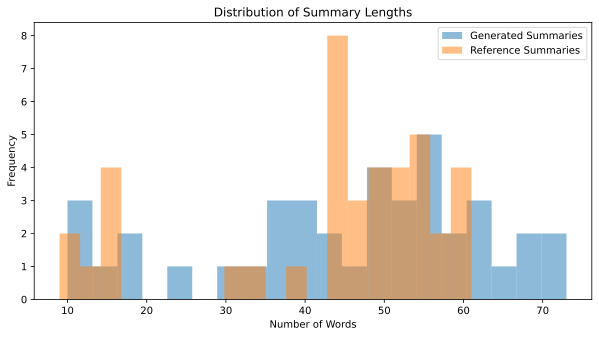

In [ ]:
# Calcola le lunghezze dei riassunti generati e dei riferimenti
generated_lengths = [len(text.split()) for text in predictions]
reference_lengths = [len(text.split()) for text in references]

# Plotta l'istogramma delle lunghezze
plt.figure(figsize=(10, 5))
plt.hist(generated_lengths, bins=20, alpha=0.5, label='Generated Summaries')
plt.hist(reference_lengths, bins=20, alpha=0.5, label='Reference Summaries')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Summary Lengths')
plt.legend()
plt.show()


## **Misure di accuratezza**

Calcoliamo le misure di accuratezza del modello

#### **ROUGE**

La misura ROUGE in questo caso è formata da ROUGE-1, ROUGE-2 e ROUGE-L, che ROUGE 1 e 2 indica la sovrapposizione degli n-grammi, quindi nel caso in questione dell'unigramma e del bigramma. ROUGE-L invece riguarda la lunghezza delle sequenze

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(predictions, references, avg=True)

# Stampa i risultati
print("ROUGE Scores:")
print(f"ROUGE-1: {scores['rouge-1']}")
print(f"ROUGE-2: {scores['rouge-2']}")
print(f"ROUGE-L: {scores['rouge-l']}")

ROUGE Scores:
ROUGE-1: {'r': 0.30966599826995134, 'p': 0.28076551186967996, 'f': 0.2889366056951176}
ROUGE-2: {'r': 0.14934077175274546, 'p': 0.13067360460099292, 'f': 0.13666568252977598}
ROUGE-L: {'r': 0.28596560200298315, 'p': 0.25964533165497883, 'f': 0.266893847936434}


#### **BLUE**

La metrica BLUE non è propriamente adatta alla text summarization, è utilizzata in modo efficace nella traduzione, perché il testo generato dal modello deve corrispondere in modo fedele al testo reale, ma per la sintesi dei testi questo non vale, perché in parole diverse si può esprimere lo stesso significato.

In [ ]:
# Calcola BLEU per ogni coppia di predizione e riferimento con smoothing
smoother = SmoothingFunction().method1  # Puoi sperimentare con metodi diversi
bleu_scores_smoothed = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smoother) for ref, pred in zip(references, predictions)]

# Calcola BLEU per l'intero corpus con smoothing
corpus_bleu_score_smoothed = corpus_bleu([[ref.split()] for ref in references], [pred.split() for pred in predictions], smoothing_function=smoother)

# Visualizza i risultati con smoothing
print(f"BLEU Scores with Smoothing (per ogni coppia): {bleu_scores_smoothed}")
print(f"BLEU Score with Smoothing (intero corpus): {corpus_bleu_score_smoothed}")


BLEU Scores with Smoothing (per ogni coppia): [0.004451963616250483, 0.10266955198877506, 0.011961709986958346, 0.49915938920340513, 0.01365914929695545, 0.363622704650007, 0.005203300368769517, 0.015634762919024457, 0.40826691498313367, 0.005049952642989119, 0.010193843668780917, 0.005151402656838269, 0.00707605312908826, 0.012655561198673315, 0.057446387286086247, 0.14908960803395838, 0.036817760899933355, 0.10016820495011315, 0.005025594790515843, 0.02624308202742789, 0.004123762330794954, 0.010084325049930443, 0.05423392627485669, 0.12630318292679518, 0.003367842053959438, 0.004324532546840044, 0.019489251419289165, 0.014121353246434959, 0.762465858623486, 0.005739995047374933, 1.0, 0.034039211846625915, 0, 0.006195258373090771, 0.011503349393390701, 0.004324532546840044, 0.004579364614898171, 0.0057583984408872396, 0.0055913101225260695, 0.007048793693474341]
BLEU Score with Smoothing (intero corpus): 0.057021683860861205


## **Esempio di text summarization**

Esempio dell'utilizzo del modello di text summary su un articolo della rivista IlPost in ambito tecnologia, non presente nel dataset né di train né di test.

In [ ]:
from transformers import MBartTokenizer, MBartForConditionalGeneration
tokenizer = MBartTokenizer.from_pretrained("ARTeLab/mbart-summarization-ilpost")
model = MBartForConditionalGeneration.from_pretrained("ARTeLab/mbart-summarization-ilpost")
model.load_state_dict(torch.load('/content/drive/MyDrive/Prog_NLP/tesxsumm_bert.pkl'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
file_path = "/content/drive/MyDrive/Prog_NLP/Tastiera.txt"
with open(file_path, "r", encoding="utf-8") as file:
    input_text = file.read()


input_ids = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)['input_ids']
model.eval()
with torch.no_grad():
    summary_ids = model.generate(input_ids)

# Decodifica il riassunto
summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Stampa il riassunto
print("Riassunto generato:")
print(summary_text)

Riassunto generato:
Come nacque il tasto “Copilot” di WindowsIl primo aggiornamento del sistema operativo è stato presentato trent'anni fa, e conferma il grande interesse di Microsoft per gli intelligenza artificiali. Il primo aggiornamento del sistema operativo è stato presentato trent'anni fa, e conferma il grande interesse di Microsoft per gli intelligenza artificiali.
